## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors: Paul Doucet, Jerry Khidaroo

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

#### Load Data

In [3]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [4]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

Down sample to 1000 records.

In [5]:
print ((1000 * 1000)//7708)

129


In [6]:
# Get 50 per instruction_id then reduce to 1000
def sampling_k_elements(group, k=130):
    if len(group) < k:
        return group
    return group.sample(k)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to 1000
corpus_df = corpus_df.sample(n=1000, random_state=1)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    78
coffee-ordering-1     73
coffee-ordering-2     79
movie-finder          36
movie-tickets-1       80
movie-tickets-2       79
movie-tickets-3       76
pizza-ordering-1      70
pizza-ordering-2      81
restaurant-table-1    72
restaurant-table-2    73
restaurant-table-3    65
uber-lyft-1           71
uber-lyft-2           67
dtype: int64


#### Create Factorized 'category' column from 'Instruction_id' label column.

In [7]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

,selfdialog_clean,Instruction_id,category
111,"Hello, I would like to schedule an appointment to get an oil change? sure, What type of car needs the oil change. a 2010 Jeep Liberty Is there a day that works better for you? Saturday at 11 works for me We have that time available. Great Can I get you info to schedule the appointment sure it's Stephanie Meyer and my number is 563-599-1111 Thanks. Can you also check the tire pressure while you have it sure we do a full inspection that is great. Anything else please let me know if anything needs to be fixed we sure will Thank you for all your help. You are welcome I will see you on Saturday Great, see you then",auto-repair-appt-1,0
126,"I'm calling so you can make me an appointment for a few car repairs at my regular dealers shop at ""Intelligent Auto Solutions"". Ok, for which vehicle? I need the year, make, and model. For my 2018 BMW Series 5 ok, I'm punching that into the website now. Yes, you can give my name as Jan Olsen and my phone number is 313-777-0777 Ok, copy that. And, what problems are you having with the car? It's not starting right away (kind of grinding) and it's hesitating when I switch gears. I want a tune up and an oil change as well. Ok, I've got all that. Do you want an estimate on those repairs and maintanence jobs plus an inspection fee? Yes, you've read my mind, thanks Ok, I'll send an email and get back to you. Also, find out when the soonest we can get the car in because I'm going on a business trip next week and I need that taken care of before I leave next Friday, April 5th. I will take care of all of that, yes, I'll call back soon. Ok, I'll be waiting for your assistance. Hi, yes the shop has an opening tomorrow morning at 10am, will that work for you? No, I am tied up tomorrow and the next day. Ok, I'll call him and see what else he has open and i'll call you back. Ok, thanks again. Ok, he has an opening on Monday and if you drop off the car on Friday night, he can have it repaired and running on Monday afternoon at 5pm. Will that work? The inspection fee will be $200 and the total fee is estimated at $740. Yes, that will work. Set it up and send me the details on my phone via text messages. Thank you for your help. Ok, text messaging to your mobile device is: Yes, confirmation for Jan Olsen phone number is 313-777-0777. For my 2018 BMW Series 5 It's not starting right away (kind of grinding) and it's hesitating when I switch gears. I want a tune up and an oil change as well. Estimated fees including inspection fee and everything else is ~ $740. Thank you very much. You are very welcome.",auto-repair-appt-1,0
555,"Will you buy me tickets to see ""The Lego Movie 2""? What theater would you like me to purchase the tickets at? The Grand Conroe. What city is that in? Conroe, Texas How many tickets would you like? Two tickets. What day did you want to go? This evening, if possible. There are showtimes at 6:30 PM and 9:00 PM. I would like the 9:00 PM showtime. How many tickets would you like to purchase? Just two, please. Would you like for me to put any special instructions on your reservation? No, that will not be necessary. Is there anything else I can do for you? No, that will be all. Ok, I have sent all the information to your phone. Have fun. Thank you, bye Bye.",movie-tickets-1,1
1260,"I'm looking for a good Mexican restaurant You should go to Los Toltecos, it's amazing. Sounds good. Can you make a reservation for two on Friday? Sure, what time were you thinking? 7 pm? That time isn't available. Okay, how about 8 pm? They only have an opening at 9 pm. 9 pm is a little late, do you know any other Mexican restaurants? Yes, theres this place called Los Tios that has the best fajitas and queso. Perfect. Did you still want a 7 pm reservation? Yes, if possible. That's available. Awesome! Can you make it for 3 people instead of 2? Absolutely. Do they have patio seating? They do. Can you request the patio for me? Done and done! Thank you! You're the best!",re

#### Word Embeddings

In [8]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [9]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [12]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

,selfdialog_clean,Instruction_id,category,selfdialog_norm
111,"Hello, I would like to schedule an appointment to get an oil change? sure, What type of car needs the oil change. a 2010 Jeep Liberty Is there a day that works better for you? Saturday at 11 works for me We have that time available. Great Can I get you info to schedule the appointment sure it's Stephanie Meyer and my number is 563-599-1111 Thanks. Can you also check the tire pressure while you have it sure we do a full inspection that is great. Anything else please let me know if anything needs to be fixed we sure will Thank you for all your help. You are welcome I will see you on Saturday Great, see you then",auto-repair-appt-1,0,hello would like schedule appointment get oil change sure type car needs oil change jeep liberty day works better saturday works time available great get info schedule appointment sure stephanie meyer number thanks also check tire pressure sure full inspection great anything else please let know anything needs fixed sure thank help welcome see saturday great see
126,"I'm calling so you can make me an appointment for a few car repairs at my regular dealers shop at ""Intelligent Auto Solutions"". Ok, for which vehicle? I need the year, make, and model. For my 2018 BMW Series 5 ok, I'm punching that into the website now. Yes, you can give my name as Jan Olsen and my phone number is 313-777-0777 Ok, copy that. And, what problems are you having with the car? It's not starting right away (kind of grinding) and it's hesitating when I switch gears. I want a tune up and an oil change as well. Ok, I've got all that. Do you want an estimate on those repairs and maintanence jobs plus an inspection fee? Yes, you've read my mind, thanks Ok, I'll send an email and get back to you. Also, find out when the soonest we can get the car in because I'm going on a business trip next week and I need that taken care of before I leave next Friday, April 5th. I will take care of all of that, yes, I'll call back soon. Ok, I'll be waiting for your assistance. Hi, yes the shop has an opening tomorrow morning at 10am, will that work for you? No, I am tied up tomorrow and the next day. Ok, I'll call him and see what else he has open and i'll call you back. Ok, thanks again. Ok, he has an opening on Monday and if you drop off the car on Friday night, he can have it repaired and running on Monday afternoon at 5pm. Will that work? The inspection fee will be $200 and the total fee is estimated at $740. Yes, that will work. Set it up and send me the details on my phone via text messages. Thank you for your help. Ok, text messaging to your mobile device is: Yes, confirmation for Jan Olsen phone number is 313-777-0777. For my 2018 BMW Series 5 It's not starting right away (kind of grinding) and it's hesitating when I switch gears. I want a tune up and an oil change as well. Estimated fees including inspection fee and everything else is ~ $740. Thank you very much. You are very welcome.",auto-repair-appt-1,0,im calling make appointment car repairs regular dealers shop intelligent auto solutions ok vehicle need year make model bmw series ok im punching website yes give name jan olsen phone number ok copy problems car starting right away kind grinding hesitating switch gears want tune oil change well ok ive got want estimate repairs maintanence jobs plus inspection fee yes youve read mind thanks ok ill send email get back also find soonest get car im going business trip next week need taken care leave next friday april th take care yes ill call back soon ok ill waiting assistance hi yes shop opening tomorrow morning work tied tomorrow next day ok ill call see else open ill call back ok thanks ok opening monday drop car friday night repaired running monday afternoon pm work inspection fee total fee estimated yes work set send details phone via text messages thank help ok text messaging mobile device yes confirmation jan olsen phone number bmw series starting right away kind grindi

In [13]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

1000


['im calling make appointment car repairs regular dealers shop intelligent auto solutions ok vehicle need year make model bmw series ok im punching website yes give name jan olsen phone number ok copy problems car starting right away kind grinding hesitating switch gears want tune oil change well ok ive got want estimate repairs maintanence jobs plus inspection fee yes youve read mind thanks ok ill send email get back also find soonest get car im going business trip next week need taken care leave next friday april th take care yes ill call back soon ok ill waiting assistance hi yes shop opening tomorrow morning work tied tomorrow next day ok ill call see else open ill call back ok thanks ok opening monday drop car friday night repaired running monday afternoon pm work inspection fee total fee estimated yes work set send details phone via text messages thank help ok text messaging mobile device yes confirmation jan olsen phone number bmw series starting right away kind grinding hesitat

#### Build Vocabulary

In [56]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 5929
Vocabulary Sample: [('like', 1), ('would', 2), ('okay', 3), ('ok', 4), ('yes', 5), ('want', 6), ('pm', 7), ('order', 8), ('thank', 9), ('please', 10)]


#### Build (context_words, target_word) pair generator

In [57]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [58]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['hi', 'give', 'setting', 'appointment'] -> Target (Y): hand
Context (X): ['give', 'hand', 'appointment', 'bring'] -> Target (Y): setting
Context (X): ['hand', 'setting', 'bring', 'car'] -> Target (Y): appointment
Context (X): ['setting', 'appointment', 'car', 'see'] -> Target (Y): bring
Context (X): ['appointment', 'bring', 'see', 'mechanic'] -> Target (Y): car
Context (X): ['bring', 'car', 'mechanic', 'sure'] -> Target (Y): see
Context (X): ['car', 'see', 'sure', 'problem'] -> Target (Y): mechanic
Context (X): ['see', 'mechanic', 'problem', 'looking'] -> Target (Y): sure
Context (X): ['mechanic', 'sure', 'looking', 'take'] -> Target (Y): problem
Context (X): ['sure', 'problem', 'take', 'want'] -> Target (Y): looking
Context (X): ['problem', 'looking', 'want', 'send'] -> Target (Y): take


#### Set up Dictionaries to Cross-Refrence 'Instruction_id' and its Factorized value 'category'

In [72]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

#### Split Data into Train and Test Sets

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

#### Bag of Words Feature Extraction

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 1, 2, ..., 0, 0, 0],
       [0, 1, 2, ..., 0, 0, 0],
       [0, 2, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 6, 5, ..., 0, 0, 0]], dtype=int64)

In [45]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,ok,yes,okay,pm,want,order,tickets,time,thank,one,please,pizza,...,marin,accommodated,cinemax,seebohemian,lucked,sureokay,okayjust,sidney,billie,nicely,minuets,torn,boardwalk,coach,herman
0,0,1,2,3,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,2,3,0,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2,1,4,4,0,5,0,0,3,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2,1,2,0,4,2,1,0,0,1,2,3,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,5,1,0,0,2,1,0,0,0,6,1,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,4,2,0,2,9,0,1,4,0,0,3,1,0,5,...,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0
996,0,2,0,2,3,0,4,1,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
997,0,0,1,0,0,4,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
998,0,0,0,0,1,1,1,3,0,2,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Bag of Words Feature Benchmarking with Naive Bayes Classifier

In [130]:
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(750, 5962)
(250, 5962)
(250,)


In [131]:
naive = MultinomialNB()
classifier = naive.fit(X_train_bow, y_train)
predict_bow = classifier.predict(X_test_bow)

In [132]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predict_bow,y_test)
cm

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 16,  6,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  4, 16,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0, 21,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5, 18,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  1,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10, 14,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  2,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 11]],
      dtype=int64)

In [133]:
accuracy = cm.trace()/cm.sum()
print(accuracy)

0.704


In [134]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict_bow, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
   movie-tickets-1       1.00      0.26      0.42        19
restaurant-table-2       0.53      1.00      0.70        16
  pizza-ordering-1       0.90      0.82      0.86        11
restaurant-table-1       0.67      0.80      0.73        20
restaurant-table-3       0.73      0.73      0.73        22
 coffee-ordering-2       0.95      0.88      0.91        24
       uber-lyft-1       0.64      0.64      0.64        14
   movie-tickets-2       0.78      0.78      0.78        23
 coffee-ordering-1       0.80      0.36      0.50        22
       uber-lyft-2       0.45      0.82      0.58        17
   movie-tickets-3       0.62      0.50      0.55        16
  pizza-ordering-2       0.78      0.47      0.58        15
      movie-finder       0.58      0.85      0.69        13

          accuracy                           0.70       250
         macro avg       0.75      0.71      0.69       25

#### Feature Selection Using Chi-Squared Method

In [145]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

num_feats = 2000
X_norm = MinMaxScaler().fit_transform(X_train_bow, y_train)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y_train)
chi_support = chi_selector.get_support()
#chi_feature = X_train[:,chi_support.columns.tolist()
X_train_bow_chi = X_train_bow[:,chi_support]
X_test_bow_chi = X_test_bow[:,chi_support]
#print(str(len(X_train_bow_chi)), 'selected features')
print(X_train_bow_chi.shape)

750 selected features
(750, 2000)


Re-Run on Smaller Feature set

In [164]:
classifier_chi = naive.fit(X_train_bow_chi, y_train)
predict_bow_chi = classifier_chi.predict(X_test_bow_chi)

In [165]:
cm_chi = confusion_matrix(predict_bow_chi,y_test)
cm_chi

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  6,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 13, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 17,  5,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  3, 16,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 22,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  8,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  4, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 15, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6, 12]],
      dtype=int64)

In [166]:
accuracy_chi = cm_chi.trace()/cm_chi.sum()
print(accuracy_chi)

0.708


In [167]:
print(metrics.classification_report(y_test, predict_bow_chi, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
   movie-tickets-1       0.86      0.32      0.46        19
restaurant-table-2       0.54      0.94      0.68        16
  pizza-ordering-1       1.00      0.91      0.95        11
restaurant-table-1       0.74      0.85      0.79        20
restaurant-table-3       0.76      0.73      0.74        22
 coffee-ordering-2       0.96      0.92      0.94        24
       uber-lyft-1       0.53      0.71      0.61        14
   movie-tickets-2       0.79      0.65      0.71        23
 coffee-ordering-1       0.75      0.27      0.40        22
       uber-lyft-2       0.42      0.88      0.57        17
   movie-tickets-3       0.60      0.38      0.46        16
  pizza-ordering-2       0.90      0.60      0.72        15
      movie-finder       0.67      0.92      0.77        13

          accuracy                           0.71       250
         macro avg       0.75      0.72      0.70       25

#### TF-IDF Feature Extraction

In [64]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
#vocab_tfidf = count_vect.vocabulary_
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(750, 5056)
(250, 5056)


#### Train TF-IDF Model with Naive Bayes Classifier: Multinomial variant

In [65]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

#### Make Some Predictions

In [66]:
X_new_data_counts = count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])
X_new_data_tfidf = tfidf_transformer.fit_transform(X_new_data_counts)
print(X_new_data_tfidf.shape)
y_pred_new = clf.predict(X_new_data_tfidf)
y_pred_new

(1, 5056)


array(['auto-repair-appt-1'], dtype='<U18')

#### TF-IDF Benchmarking with Naive Bayes Classifier: Multinomial variant

In [67]:
from sklearn.metrics import confusion_matrix

y_pred_tfidf = clf.predict(X_test_tfidf)
cm_nb_tfidf = confusion_matrix(y_pred_tfidf,y_test)
cm_nb_tfidf

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4, 14,  7,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  6, 14, 12,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  0,  1, 11,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 21, 15,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  8]],
      dtype=int64)

In [68]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_tfidf, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
   movie-tickets-1       0.00      0.00      0.00        19
restaurant-table-2       0.46      1.00      0.63        16
  pizza-ordering-1       0.00      0.00      0.00        11
restaurant-table-1       0.54      0.70      0.61        20
restaurant-table-3       0.40      0.64      0.49        22
 coffee-ordering-2       0.69      0.46      0.55        24
       uber-lyft-1       0.67      0.57      0.62        14
   movie-tickets-2       0.76      0.83      0.79        23
 coffee-ordering-1       1.00      0.05      0.09        22
       uber-lyft-2       0.36      0.88      0.51        17
   movie-tickets-3       0.83      0.62      0.71        16
  pizza-ordering-2       0.55      0.40      0.46        15
      movie-finder       0.47      0.62      0.53        13

          accuracy                           0.56       250
         macro avg       0.55      0.55      0.50       25

#### TF-IDF Benchmarking with LinearSVC

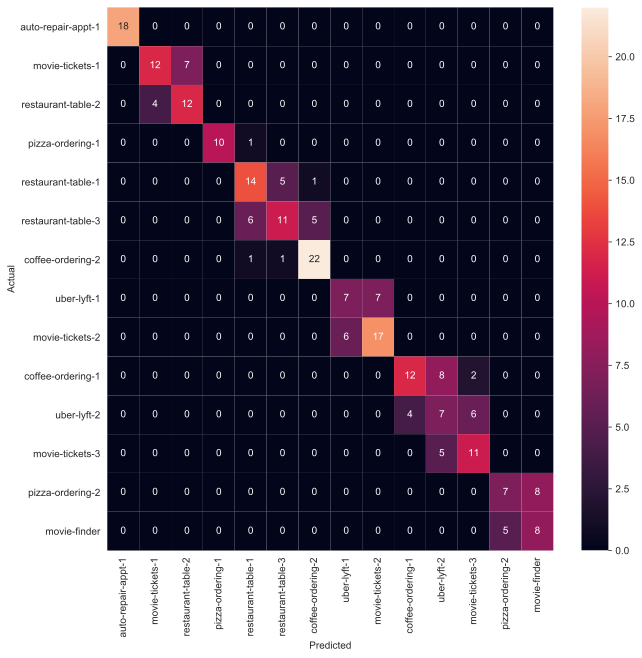

In [73]:
model = LinearSVC()
model.fit(X_train_tfidf, y_train)
y_pred_svc = model.predict(X_test_tfidf)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_svc)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Metrics For Each Class

In [74]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_svc, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
   movie-tickets-1       0.75      0.63      0.69        19
restaurant-table-2       0.63      0.75      0.69        16
  pizza-ordering-1       1.00      0.91      0.95        11
restaurant-table-1       0.64      0.70      0.67        20
restaurant-table-3       0.65      0.50      0.56        22
 coffee-ordering-2       0.79      0.92      0.85        24
       uber-lyft-1       0.54      0.50      0.52        14
   movie-tickets-2       0.71      0.74      0.72        23
 coffee-ordering-1       0.75      0.55      0.63        22
       uber-lyft-2       0.35      0.41      0.38        17
   movie-tickets-3       0.58      0.69      0.63        16
  pizza-ordering-2       0.58      0.47      0.52        15
      movie-finder       0.50      0.62      0.55        13

          accuracy                           0.67       250
         macro avg       0.68      0.67      0.67       25

#### Word2Vec Feature Extraction

In [97]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['coordinate', 'unacceptable', 'nails', 'vi', 'winslet'],
 'pizza': ['pepperoni', 'large', 'pineapple', 'bacon', 'papa'],
 'terminator': ['abyss', 'judgment', 'cameron', 'sigourney', 'weaver'],
 'star': ['wars', 'return', 'jedi', 'blade', 'iv'],
 'audi': ['debitcredit', 'wallet', 'andrew', 'pad', 'replacements'],
 'east': ['uptown', 'lower', 'cab', 'eh', 'anywhere'],
 'korean': ['bbq', 'germantown', 'italian', 'bbgo', 'lauderhill'],
 'playing': ['theaters', 'hm', 'pet', 'shows', 'popular']}

#### Visualizing word embeddings

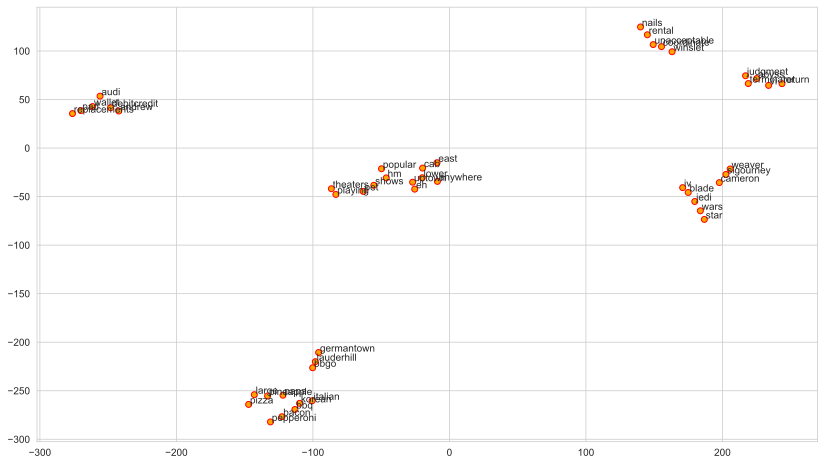

In [98]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our Train dataset

In [99]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [100]:
w2v_model.wv['jedi']

array([ 0.5714925 ,  0.25806475,  0.586848  , -0.9897551 , -0.4889227 ,
       -0.17042029,  0.57669693,  0.37966704, -0.6714364 ,  0.19955032,
       -0.0759132 ,  0.19078207, -0.42869535,  0.17583786, -0.1754732 ,
       -0.8005606 ,  0.1818368 , -0.0985381 ,  0.0466466 ,  0.06630203,
       -0.19148955, -0.04998344, -0.33413494, -0.23887861,  0.4396414 ,
       -0.20317046, -0.35665503,  0.08710258, -0.24915312,  0.07426596,
       -0.05149522, -0.3822525 ,  0.10013714, -0.682267  , -0.25527036,
        0.5238304 ,  0.55323714, -0.08953463,  0.4605628 , -0.44074786,
       -0.09573949, -0.70900244,  0.5403906 ,  0.17939815,  0.39135897,
        0.03011519,  0.71541494, -0.49519935, -0.02875712, -0.5111136 ,
        0.3881639 , -0.57585293, -0.0212488 ,  0.10670297,  0.16615441,
        0.58524626, -0.1695106 ,  0.47063905, -0.0911063 , -0.40220523,
        0.00674194,  0.12049215,  0.19483295, -0.14433247,  0.09576002,
        0.09668234, -0.6928631 , -0.34389865, -0.3057209 ,  0.31

#### Build framework for getting document level embeddings

In [101]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [102]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.09,-0.08,-0.55,1.20,-0.67,0.29,0.13,0.38,0.06,-0.17,0.07,0.70,-0.02,-0.01,1.24,...,0.58,-0.69,-0.11,0.16,-0.28,0.55,-0.35,-0.34,0.29,0.06,0.51,0.47,0.07,-0.07,0.01
1,-0.09,-0.40,0.36,0.47,-0.29,0.01,-0.39,-0.22,-0.44,0.70,0.35,0.69,-0.10,-0.34,-0.38,...,0.34,-0.11,0.73,0.57,0.09,-0.41,1.30,-0.13,-0.49,-0.05,-0.61,-0.25,-0.47,0.53,0.51
2,-0.16,-0.61,0.45,0.17,-0.61,-0.62,1.32,-0.80,0.68,-0.17,-0.54,1.24,0.52,-0.05,-0.25,...,-0.13,-0.33,-0.26,0.43,0.77,0.44,0.66,-0.46,0.13,-0.16,-0.11,0.61,-0.49,0.25,0.68
3,-0.41,-0.33,-0.05,-0.06,0.17,-0.35,0.80,-0.85,-0.63,-0.04,-0.93,0.43,0.93,0.56,-0.74,...,0.03,-0.55,0.46,0.44,0.20,-0.40,0.35,-0.45,-0.01,0.50,0.16,-0.09,-0.14,-0.17,0.21
4,-0.27,-0.26,-0.48,0.44,0.13,-0.76,-0.02,-0.09,-0.18,0.29,-1.16,0.09,0.42,-0.10,-0.52,...,0.17,-0.45,0.61,0.19,-0.16,0.20,0.64,0.03,-0.25,0.23,0.41,-0.60,-1.01,0.15,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.40,-0.28,0.22,0.64,-0.49,-0.24,0.67,-1.20,-0.10,0.19,-0.75,1.03,0.17,-0.09,-0.01,...,0.14,-0.55,0.12,0.13,0.41,0.01,0.33,-0.51,-0.56,0.58,-0.40,0.32,-0.33,0.15,0.55
746,-0.81,-0.54,-0.48,0.65,0.21,-0.76,0.52,-0.08,0.12,0.50,-0.89,0.23,0.29,-0.01,-0.16,...,0.39,-0.91,-0.16,0.39,0.80,0.11,1.49,-0.29,0.04,-0.73,0.50,-0.63,-1.08,0.33,0.21
747,-0.66,-0.50,0.08,0.96,-0.40,-0.42,0.86,-1.64,0.29,0.06,-1.18,1.18,0.31,-0.12,0.11,...,0.05,-0.63,-0.02,-0.30,0.19,-0.04,0.50,-0.79,-0.40,0.16,0.25,-0.02,-0.18,-0.17,0.22
748,-0.42,-0.53,-0.31,0.36,0.39,-1.02,-0.13,-0.27,-0.09,0.24,-0.63,0.17,1.01,-0.22,-0.88,...,0.22,-0.70,0.60,0.77,0.15,-0.12,0.53,-0.43,0.38,0.14,-0.02,-0.16,0.07,0.22,0.38


In [103]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

(250, 100)


#### Word2vec Feature Benchmarking with LinearSVC Classifier

In [104]:
from sklearn.svm import LinearSVC

model_w2v = LinearSVC()
classifier = model_w2v.fit(w2v_feature_array, y_train)
predict_w2v = classifier.predict(w2v_test_array)

In [105]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predict_w2v,y_test)
cm

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  8, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 13,  6,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  6, 11,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  5, 23,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  4, 18,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  3,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  8,  5,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  6, 11,  0,  0],
       [ 0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  9,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  7]],
      dtype=int64)

In [106]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict_w2v, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
   movie-tickets-1       0.79      0.58      0.67        19
restaurant-table-2       0.62      0.81      0.70        16
  pizza-ordering-1       1.00      0.91      0.95        11
restaurant-table-1       0.65      0.65      0.65        20
restaurant-table-3       0.61      0.50      0.55        22
 coffee-ordering-2       0.82      0.96      0.88        24
       uber-lyft-1       0.71      0.71      0.71        14
   movie-tickets-2       0.82      0.78      0.80        23
 coffee-ordering-1       0.79      0.50      0.61        22
       uber-lyft-2       0.35      0.47      0.40        17
   movie-tickets-3       0.58      0.69      0.63        16
  pizza-ordering-2       0.53      0.60      0.56        15
      movie-finder       0.58      0.54      0.56        13

          accuracy                           0.69       250
         macro avg       0.70      0.69      0.69       25

## Additional Advanced Methods To Explore Further

#### GloVe Embeddings with spaCy

In [14]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [21]:
unique_words = list(set([word for sublist in [doc.split() for doc in X_train] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

In [18]:
unique_words_test = list(set([word for sublist in [doc.split() for doc in X_test] for word in sublist]))
word_glove_vectors_test = np.array([nlp(word).vector for word in unique_words])
print(word_glove_vectors_test.shape)

(5027, 300)


#### Word2vec features with Fastext Model

In [26]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [27]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['capital', 'would', 'steaks', 'like', 'great'],
 'pizza': ['pepperoni', 'pizzas', 'large', 'cheese', 'sausage'],
 'terminator': ['terminal', 'flight', 'lax', 'museum', 'airport'],
 'star': ['wars', 'recommended', 'empire', 'recommendations', 'starring'],
 'audi': ['including', 'sooner', 'seats', 'reason', 'acceptable'],
 'east': ['bay', 'oak', 'linos', 'bar', 'street'],
 'korean': ['md', 'bbq', 'germantown', 'p', 'requested'],
 'playing': ['movie', 'tickets', 'theaters', 'showing', 'theater']}

#### PCA on Fasttext Model

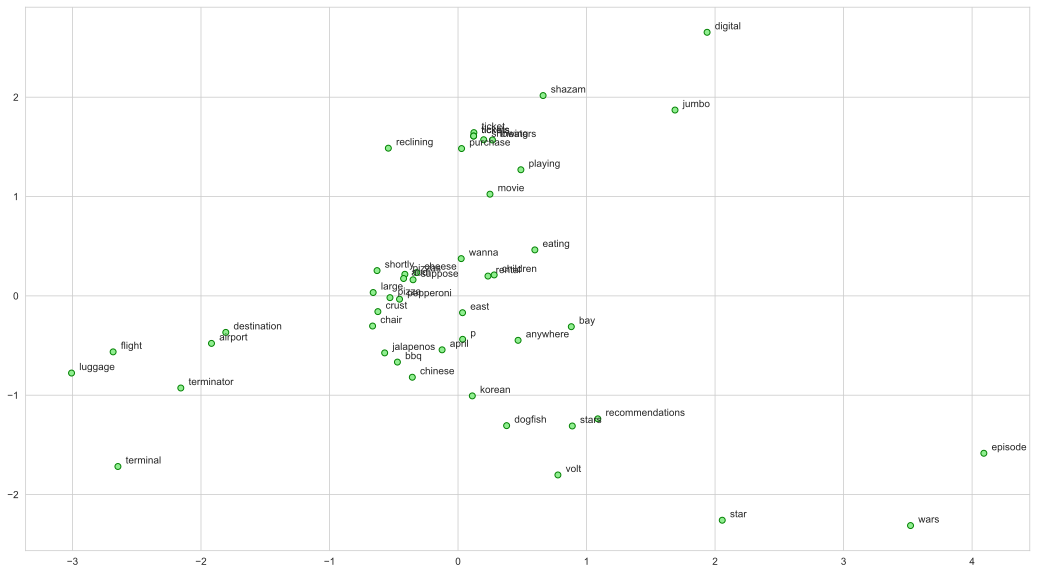

In [87]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [88]:
ft_model.wv['rental']

array([ 0.07450517, -0.13167965,  0.25574797,  0.28092408, -0.06483702,
       -0.02726901,  0.13023551, -0.00145915,  0.0135197 ,  0.04445807,
       -0.36906782,  0.61134994,  0.26041174,  0.17370118, -0.2189258 ,
       -0.1615687 ,  0.3744621 ,  0.24338971, -0.09539401, -0.41563097,
        0.04828969, -0.09737606, -0.19534032,  0.28214082, -0.32199788,
        0.19340488,  0.03056893, -0.2903258 , -0.18622367, -0.02856769,
        0.09626462, -0.02446979,  0.20208485, -0.0803023 ,  0.13698581,
        0.42477515, -0.16757128,  0.00660062,  0.12433224, -0.21680434,
        0.0186085 , -0.1570227 ,  0.06158876, -0.1005422 ,  0.07963058,
       -0.3103401 ,  0.43043658, -0.546535  , -0.3248    ,  0.5103326 ,
       -0.23345195,  0.4399872 ,  0.21430226, -0.26340443, -0.13662468,
        0.12817457,  0.12574199,  0.5267605 ,  0.17208391, -0.29794228,
       -0.20484763,  0.3104489 , -0.07131893, -0.0442618 ,  0.26576713,
       -0.13874257, -0.15857488,  0.15563935, -0.0464476 , -0.00

In [89]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.21774496
0.7551302


In [90]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pies
